# Single frequency component modelling of speech

This notebook will examine the plausibility of modelling the real and imaginary part of warped frequency coefficients using an auto-regressive model.

This notebook comprises the following steps:
1. Load data
2. Pass data through warped filter bank and calculate warped frequency coefficients
3. Model the warped frequency coefficients using an auto-regressive model
4. Infer auto-regressive parameters
5. Evaluate performance on coefficient prediction

## Load packages and functions

In [21]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **



In [22]:
Pkg.status()

    Status `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`
  [34da2185] Compat v3.10.0
  [717857b8] DSP v0.6.7
  [31c24e10] Distributions v0.22.6
  [7a1cc6ca] FFTW v1.2.1
  [9fc3f58a] ForneyLab v0.10.0 #master (https://github.com/biaslab/ForneyLab.jl.git)
  [cc18c42c] GaussianMixtures v0.3.2
  [c3bc7fac] LAR v0.1.0 [`C:\Users\s151781\.julia\dev\LAR`]
  [92933f4c] ProgressMeter v1.3.0
  [d330b81b] PyPlot v2.9.0
  [8149f6b0] WAV v1.0.3


## Adjustable parameters

In [23]:
# signal preprocessing
sound_file = "../data/obama.wav"      # specify sound location
fs_desired = 8000                 # specify desired sampling frequency

# signal warping
buffer_size = 32                # number of taps of warped filter bank
step_size = 1
window = rectangularwindow         # specify windowing function from fourier.jl file

# inference and modelling
bin = 3                           # specify which bin to model (should be between 1 and half `nr_taps_warped`)
bin_c = "real"                     # specify whether to model the `real` or `imaginary` part
AR_order = 20                       # order of auto-regressive model
iterations = 5                     # number of iterations for variational message passing
Λ_meas = 1e4                      # assumed precision of measurement noise
;

## Load data

In [24]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[20*fs_time+1:23*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCnCOW8wa2AvsC2BL3R5W49mfDVvQbAob3dP4e+AVH2vZZYaTxgBAu9CZfmPO4m7r2QBDm9BUgRPnOnYD39fSg9Hupave+yprw3dLc9gd8iO8F+a72y35i8LSgMPVvOYj7uO+090rUIvgCzSz2afRQ++WxGPrrIGj1J1Eu+9WEVuUv/8byzSAW+6pLavQzAgr6Zld69M4guvLO5YDyyPbc9vyLQvVZskb22nLU9To6SPSU4nD2pd/K80HVUvQV9PT1KJw+77lO2vJXQHjwySjw91LlDPuzn5D3ewZC96/jQPRb28z2IKRg+sQo9PPjLMb69Iqk8MbJ2vVxQBr7YjHW9ky89vosUib3ef5e8TDHqvMTAhT1I0gm+bZyNvTqlpD29lLo993ANPugwkzpQky+9kbk0PONVQb0dyg29CQAFPdA5xD19Zlc+bTqgPVKLlr2cW8M9Wh3BPSHxAT5yHeS8CHMivlG+zTyig6a9a5H9vfVFsr0tPia+cjssvb6YaL3OlBe9liEWPNLv672fF128mGPTPUGU3T1Pc+A9K704vQ9nZb2cfFC80s6hvBocqDo6DLA9ySEFPhfoLD7xhFw9Wuyxva3Gzj1YuPE99XX3PS/h5rx21SO+T8b2PPrmu71tB769oLSZvSXvK75Jv0+9fDezvXHwQr2aM/E7gOvYvXEy1TmvRMM9oG2LPdwMMz1+/KO9QbElvahdhzxjlqY8kOdePaSQWT2hZQM+GUwQPsSClD05cLC83a3EPZ02DD6d9pQ9Zy0cvbg/Ib70j4y8AUR3vX6WjL1+GRG9SOIIvleTo7047b+9Ey4ivWqKA7uXB+K9Kv/QvNqORz2Mmn09r/fTPDzrg70iAXe8o66WPKc8CD09HZk9ZDL7PFWvyD0nj/I902iUPeOIDT0evGQ9gRaiPaJ4Az0QwRa9bPlmvQZhKrsMUFs8kNaNvPl0Kr0M43S96uCzvYe2xL0p36C6ruyxPMZzhL1d1FW90X4mvW3NFbvGaia8p1ZKvZwLebs8Dp27xPmtPGY2Hj0SPQe8jJ5gPGDY9zy2rAY985yhPK5DTrwq6Aw9ROxhPURgFT1Ca089jAY3PfMC3Tz6ep08LQA6vCbX0jrCh7a6njyduTnO1DwPfwC7y2J0va8ulL0PPrO9fApnvWsEorz5nia9cK7wvNduxrwO1tq8CyfsvFoi6bwcWqW8tfnbvH+Vqrwnzkc79SqSPOgg1DyUcyU9zJ6JPbB5Ej2U1T09yeVVPQ6HQz2R7WA9UvxRPRlKNj0QlDw9vDm7O+4ay7x7phe9pB1yvbG8Kb2i4JO8m3M5vOTBl7zkEym9Ly1VvYyRtLzNz3u8jzyqu4iKDbz8Ca682czavPI9PL3Y7i29b8wfuzZUCzsqo+k40GutPFzjpjwDRFk9va52PWKJmj0CnZg9zqBiPUVi5DxIldo8K8jzO5LReLtKiIg74SUlPPo6BrsIOKG8tSbovAXfCb2GUhS9VNUAvUJolbwkDI+89bobvcMDQL1Ljsu8EMAmvLiGprtBTd68VBQAvSyYW72bbTq9BDQfvNxkojwNWh49Qo9fPU7fVz1lBUE9Sh4ZPb+OpzzBfug8WGsYPZKUsDyfdBY9dGbjPIJaiTx7puE8LbF5vJ9ClLuUIrC80XGBvXgNLb1XuTe9Kr0VvcPTHjwC9cE70A65vNbbKL3LkTm9eKYDvdey+byWaFm82UYxu2L0lby7Zqg6w2FuOkTWrLoqiaQ8Y0JSPKjgbT3RW6I9Dvx0PQcPNz2WcGg8DEkevKyeEjyzYqI8bkNZPItixjt76kO8P4CWvA8727neH2K8ZqkkvB3M4LycNzS9mRNcvBnuEbvM83888EU6PNhZ/Ly1pVa9MtdXvYfrer0vYRG96Iozu6SKkTyowl49LBQ6PUQZPT1JHxs962vnPLbOOj0JGQs9TNsSPXcrAj2pnUs74OAcPETD3Lstto+89PT3u74zObwelTO8rzLZO6H3qruRRZa8vPrYvH+fIr0yQku9j8hNvVLrH71yTYa9kkaJvbQVO73SsM+8KnXZuZQVgbov2go7b/mkPKc0MTwSBQY9soGAPQpNUz3O+G092EhSPa/MHD3FjBc9XVuWPJ6rATw5D9Y7bP01vCkkkTs5Vr67cAAiPEM/7jxtgTk7Lw9xvPCoJr3tTHO9tOMjvZ7qNL1f/l69c1bhvAvvGL0OGd28vRocvCVfJ7wOp3m8/9YNvLWaV7wVUoU8jrOJPO06DT3u+1A9a4FtPQGypz2xXV89ufICPXgbMj0tXSs9dAVFPcny9Dz7c8O7W3SyvOw5Cr18Xsq8GO6buylumbvzv8i8da8ZvDol4rx/KU68WkEAverFhr0dbKC9O6Wevbezi735Rka9wK4Rvd2fb7zyMJC75hrgO3DlrjzXIFI8jjzNPIziVj0qSoo9E62ePc41kz0aolw9eCD1PAgrebs8NgW8onu/vOPICb2OWvm8HNrBuzOOITynq648f1wou7oX4btw7eW8BWsuvfxYg73EGrO9RVixvaNqqL2ik5G9Znc5vTK8+ryBJ2O8l4LXup3bJDx+ki09/I+PPRnMwT2DH8U9Qv+VPSxJWT2SKU898iCbPHz7Ej2z6cM8teByPHX6uTx48z88TcYtPDtXOTwZGkW853urOueCn7yq5E+9hpc7vXKLnL16m269it4lvQBKE73qnNa8oyI6vU3AGL3pC228L5NFPBAJUj3FVx49289APZI/bz28cWY9antnPeUHjD33DIc9nat/PYh/Xz10Rg09+5wOPZL2pTwQY0M8RAeTPETxWDxAT4u60DDKvPlVR704xBi91fhUvbA7W72ef1K9DDOSvYutW73uF/i8x3ubvD1Cbjz7xC48/s43PDicqLzkfBy9bThKvKmhkDlrKWA9ZNGKPdg7lD1Yh5o9b5CYPXh9pj3kJaI9KdRTPUegVD2RmYY8XfE/uw2Am7tAePi6g/EKuo4y0rz4foS9k1mUvUnttr1k3Yy9zdE8vYZpQr2JU6K8MUwHvTtwHL0+uRO9tHdFvaKgeb3zBhq9D4cnvVCsr7wHpKC83ZmNu5d0HT1wD2E9Jz1oPbMwhD3j1Fg9Ze8XPYjF6DxHbIm8kbqqOyEIt7tdDBe9SBcWvWoImr1Hlye96JQDvbf48bx4wS68Yx4HvUPrSbzyE9y8YbRBvZXpQL1BDDy9bIMlvWmnRLyG8IO8tqmavDEYbLzdM4G8jkMrPZHYiDyisT897XKAPJqdPj220II9x4M4PULRHD2b+gE5uUqZvPXX2jl0xdi8pZd9vBmjm7zCueK8DWJXu+tWN7llOdu8UftqvddGgr3J0Xm9HDCFvDN5Ir2omTi988wKvaf8jb21sga8iJoCvZaMIjzieoQ8fEUjPSaCnT3lODc99qaoPYfOVD2cLS89nFxZPWsgODuAGeo8tNlKvA3YCD0YjZw9nDIJPRWLPT3DWzq9/sNxvMaVOr2aW5K8ElMAvJ1rA72IYDS7PMocvRW9ZbxkgDi9+NA1vQe/WLwjC/i8ovIIvHJuHL2qh1k9PokvPQqU9D182qw9TQOzPaAVabvOdom8eo7RPUjUWj3wO989g+kiuuAoKzzI55k9XsOjvCgQKT08i1K8xi0wvVELgrtSlj+91IYGu4haaL1gy4q92NHgvN1ovLzaNk29r1iWvD53Qb2NhiO9z0IoOykD+Dx0WIU9wNeSPXmrnj1iWsc9mKhtPZmxjbzLVxI+vwnRPbCiAT4FRYY87CC+vetVjD3aOou9nqoFvYGwSL0Syw++9X9EvYxdgb15DAK96fMBvZAbBr596kC9dji9OlQIA71U2Ac8Qti1vO3cTTsUajQ9jkO/PC/MXj0uh

## Visualize data

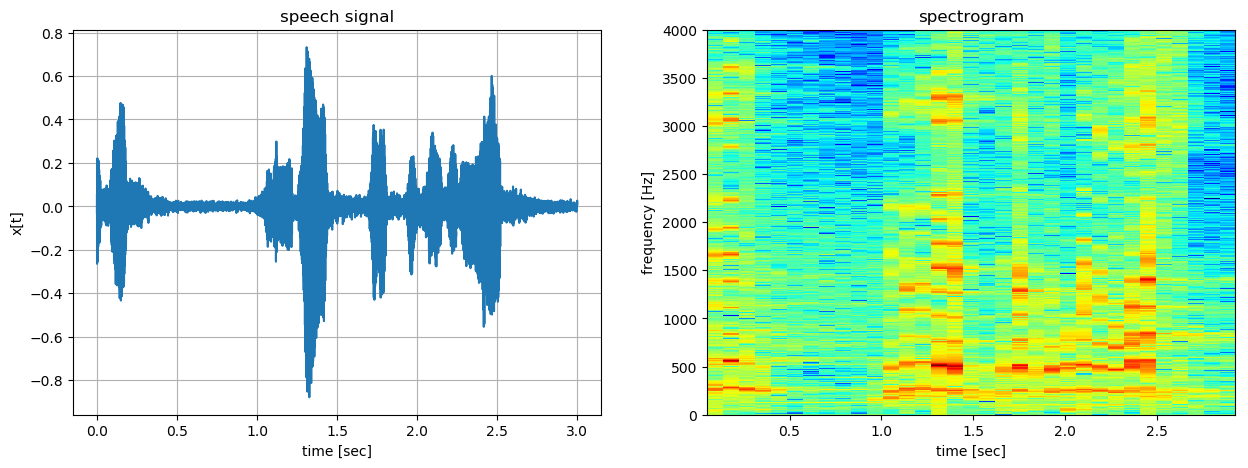

In [25]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Calculate frequency distribution

In [26]:
# initialize memory struct for filter taps and spectrum coefficients
mem_spec = Array{Complex{Float64},2}(undef, length(x_time), buffer_size)

buf = BufferData(x_time, t, buffer_size)


# loopt through time-domain signal
for k = 1:len(buf, step_size)
        # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(buffer_size).*(buf.buffer_s .- mean(buf.buffer_s)))
    
    FLAG_data_remaining = step!(buf, step_size)

end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if buffer_size%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(buffer_size/2)], conj.(mem_spec[:, Int(buffer_size/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(buffer_size/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
;

## spectral distribution visualization

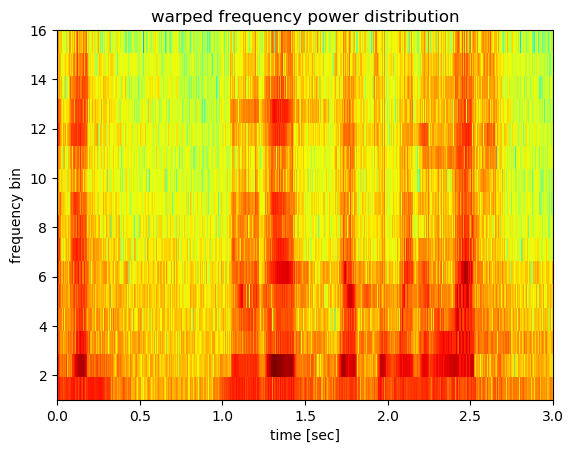

In [27]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(buffer_size/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Single bin visualization

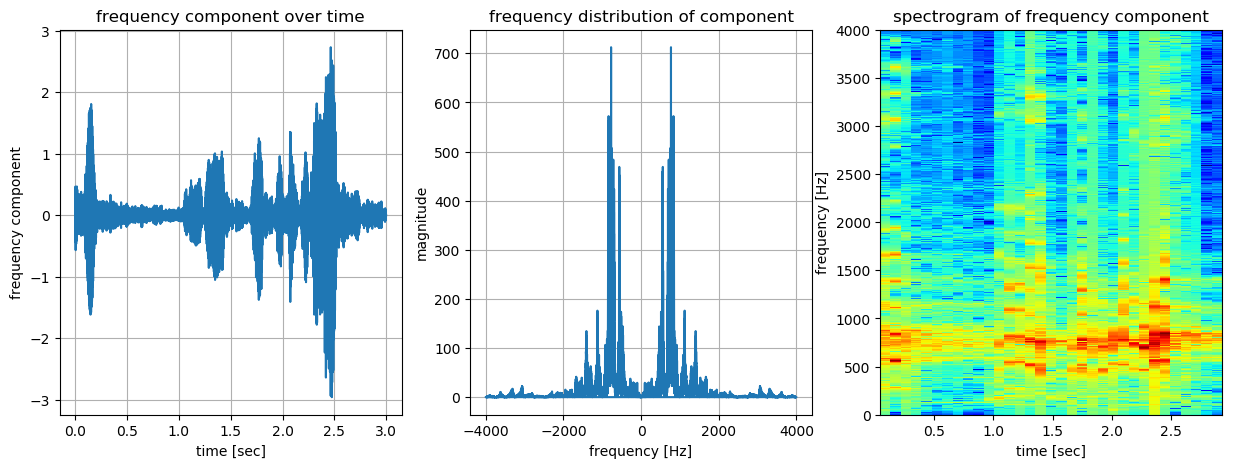

In [28]:
# select specified frequency bin
if bin_c == "real"
    spec_select = mem_spec_real[:, bin]
else
    spec_select = mem_spec_imag[:, bin]
end

# create subplots
_, ax = plt.subplots(ncols=3, figsize=(15,5))

# plot frequency component as a function of time
ax[1].plot(t, spec_select)

# plot frequency distribution of frequency component
ax[2].plot(FFTW.fftfreq(length(spec_select), fs_desired), abs.(FFTW.fft(spec_select)))

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(spec_select, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])

# change visuals
ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("frequency component over time"), ax[2].grid(), ax[2].set_xlabel("frequency [Hz]"), ax[2].set_ylabel("magnitude"), ax[2].set_title("frequency distribution of component"), ax[3].set_title("spectrogram of frequency component")
;

## Generative model and inference

In [29]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV y ~ GaussianMeanPrecision(x, Λ_meas)
placeholder(y, :y)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17490283134876021733 -->
 17490283134876021733 
 
 clamp_1 
 
<!-- 1683493294165211779 -->
 1683493294165211779 
 
 clamp_2 
 
<!-- 16031717553550790233 -->
 16031717553550790233 
 
 Gam 
 gamma_1 
 
<!-- 16362554031032817515 -->
 16362554031032817515 
 
 placeholder_a_γ 
 
<!-- 16031717553550790233--16362554031032817515 -->
 16031717553550790233--16362554031032817515 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 12514895826088991927 -->
 12514895826088991927 
 
 placeholder_b_γ 
 
<!-- 16031717553550790233--12514895826088991927 -->
 16031717553550790233--12514895826088991927 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 16783784323532113697 -->
 16783784323532113697 
 
 dot 
 dotproduct_1 
 
<!-- 16783784323532113697--17490283134876021733 -->
 16783784323532113697--17490283134876021733 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 7708090603392450834 -->
 7708090603392450834 
 
 AR 
 autoregressive_1 
 
<!-- 16783784323532113697--7708090603392450834 -->
 16783784323532113697--7708090603392450834 
 
 S 
 1 y 
 3 in2 
 
<!-- 1321660634543357257 -->
 1321660634543357257 
 
 placeholder_μ_θ 
 
<!-- 6314491364612409097 -->
 6314491364612409097 
 
 placeholder_y 
 
<!-- 7082489779102665385 -->
 7082489779102665385 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 6314491364612409097--7082489779102665385 -->
 6314491364612409097--7082489779102665385 
 
 y 
 1 out 
 1 out 
 
<!-- 14909597922070192813 -->
 14909597922070192813 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 10874287692692151336 -->
 10874287692692151336 
 
 placeholder_Λ_Sprev 
 
<!-- 14909597922070192813--10874287692692151336 -->
 14909597922070192813--10874287692692151336 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 948799957015762082 -->
 948799957015762082 
 
 placeholder_μ_Sprev 
 
<!-- 14909597922070192813--948799957015762082 -->
 14909597922070192813--948799957015762082 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 6759577928070830071 -->
 6759577928070830071 
 
 placeholder_Λ_θ 
 
<!-- 581553100738387512 -->
 581553100738387512 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 581553100738387512--1321660634543357257 -->
 581553100738387512--1321660634543357257 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 581553100738387512--6759577928070830071 -->
 581553100738387512--6759577928070830071 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 7082489779102665385--1683493294165211779 -->
 7082489779102665385--1683493294165211779 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 7082489779102665385--16783784323532113697 -->
 7082489779102665385--16783784323532113697 
 
 x 
 1 out 
 2 m 
 
<!-- 7708090603392450834--16031717553550790233 -->
 7708090603392450834--16031717553550790233 
 
 γ 
 1 out 
 4 γ 
 
<!-- 7708090603392450834--14909597922070192813 -->
 7708090603392450834--14909597922070192813 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 7708090603392450834--581553100738387512 -->
 7708090603392450834--581553100738387512 
 
 θ 
 1 out 
 3 θ

In [30]:
# specify recognition factorization and create algorithm
algo = variationalAlgorithm(θ, [S, Sprev], γ, ids=[:Θ :S :γ])
source_code = algorithmSourceCode(algo);
source_code = compatibility_fix(source_code)

#algo = compatibility_fix(variationalAlgorithm(q))
# evaluate algorith 
eval(Meta.parse(source_code))
;

In [31]:
println(source_code)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_Sprev], marginals[:θ], nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepS!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_Sprev]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Λ_Sprev]))
messages[2] = ruleSVariationalAROutNPPP(nothing, messages[1], marginals[:θ], marginals[:γ])
messages[3] = ruleSPDotProductOutNPG(nothing, Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [35]:
# priors
current_a_γ = 1
current_b_γ = 0.001
current_Λ_θ = 1e-4 * Ic(AR_order)
current_μ_θ = randn(AR_order)
current_μ_Sprev = randn(AR_order)
current_Λ_Sprev = 1e-4 * Ic(AR_order)
F_tot = []
a_γ_tot = []
b_γ_tot = []
μ_S_tot = []
Λ_S_tot = []
μ_θ_tot = []
Λ_θ_tot = []
μ_pred = Float64[]
Λ_pred = Float64[]

p = Progress(length(spec_select), 1, "Observed ")

marginals = Dict()

# create messages array 
messages= Array{Message}(undef, 6)

# loop through signal samples
for sp in 1:length(spec_select)
    
    # update progress bar
    update!(p, sp)
    
    # update marginals
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_θ, w=current_Λ_θ)
    marginals[:γ] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=current_a_γ, b=current_b_γ)
    marginals[:Sprev] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_Sprev, w=current_Λ_Sprev)
    
    # update data dictionary
    data = Dict(:y => spec_select[sp],
                :μ_Sprev => current_μ_Sprev,
                :Λ_Sprev => current_Λ_Sprev,
                :μ_θ => current_μ_θ,
                :Λ_θ => current_Λ_θ,
                :a_γ => current_a_γ,
                :b_γ => current_b_γ)
    
    # perform VMP iterations
    for it = 1:iterations
        
        # perform inference
        stepS!(data, marginals, messages)
        if it == 1
            # perform 1 step prediction
            push!(μ_pred, ForneyLab.unsafeMean(messages[3].dist))
            push!(Λ_pred, ForneyLab.unsafePrecision(messages[3].dist))
        end
        stepγ!(data, marginals, messages)
        stepΘ!(data, marginals, messages)
        
    end
    
    # fetch new parameters
    current_a_γ = marginals[:γ].params[:a]
    current_b_γ = marginals[:γ].params[:b]
    current_μ_S = ForneyLab.unsafeMean(marginals[:S_Sprev])[1:AR_order]
    current_Λ_S = inv(ForneyLab.unsafeCov(marginals[:S_Sprev])[1:AR_order,1:AR_order])
    current_μ_θ = ForneyLab.unsafeMean(marginals[:θ])
    current_Λ_θ = ForneyLab.unsafePrecision(marginals[:θ])
    
    # save new parameters
    push!(a_γ_tot, current_a_γ)
    push!(b_γ_tot, current_b_γ)
    push!(μ_S_tot, current_μ_S)
    push!(Λ_S_tot, current_Λ_S)
    push!(μ_θ_tot, current_μ_θ)
    push!(Λ_θ_tot, current_Λ_θ)
    
    # update hidden state
    current_μ_Sprev = current_μ_S
    current_Λ_Sprev = current_Λ_S
end
;

Observed   5%|██                                        |  ETA: 0:08:29m

ErrorException: PosDefException: Matrix is not positive-definite, even after regularization. Array{Float64,2}:
[9.531954033485401e8 2.059598285229717e8 -1.4508623325705385e7 4.1505390874042204e6 2.932257471941202e7 3.6431183810090736e7 3.422886696623961e7 2.3050729875292152e7 1.0016149461614264e7 -1.0678768755599426e6 -1.0266972232715333e7 -1.7117881443791993e7 -2.171860810470356e7 -2.3254088715436205e7 -2.201603510529156e7 -1.7898812209800627e7 -1.1706195647996727e7 -4.3396322462999355e6 5.7862086079639755e6 1.7646632581997246e7; 2.0595982806658944e8 6.110772008163965e8 1.5749950438476099e7 -4.1510081489202995e6 2.2278432609828557e6 2.0409903710473694e7 2.1246825092701796e7 1.4187568626544189e7 4.476680719091873e6 -2.462429214947322e6 -6.586366945260499e6 -9.806106239164466e6 -1.2262344104597017e7 -1.3271712622315217e7 -1.2528143532952232e7 -1.0178006616909718e7 -6.607976472312402e6 -2.310969469873161e6 3.2762026184956776e6 1.006750720052843e7; -1.450862313475509e7 1.5749950485757008e7 2.183960211697378e8 1.602169489988213e7 -1.4970412779664801e7 -1.44138484522337e7 2.0992472121803896e6 1.652369758790674e6 -426843.61288140935 -2.0196166858806205e6 -1.886138914128115e6 -1.3775066729565333e6 -971412.3606927593 -965809.8039832244 -1.0840418693564527e6 -859851.940930479 -479729.0467594519 -139061.8972230532 361700.71593524533 994567.7870210522; 4.150539275274506e6 -4.1510080136583215e6 1.6021694890019055e7 2.0013142247290838e8 -4.823280228803559e6 -2.68472055327984e7 -1.8626394259742208e7 -1.0952320537990307e7 -5.528247457201337e6 -526173.1667911363 3.137853977146531e6 6.107554929960178e6 8.67633967009592e6 9.853176936378306e6 9.374853113263836e6 7.570159042851198e6 4.949997781644052e6 1.8341045129419249e6 -2.2936605027744113e6 -7.094433589647089e6; 2.93225732123952e7 2.2278424673684975e6 -1.4970412753510298e7 -4.823279729963855e6 1.7945171376788384e8 -1.6117017986616312e7 -2.865102759926478e7 -2.0741470317075092e7 -9.86470774624545e6 207004.08706931118 7.318083353604345e6 1.1772313101716984e7 1.5122739405319713e7 1.691711305383314e7 1.6421149846138798e7 1.3484865347556096e7 8.782848370365392e6 3.1423384803067683e6 -4.1557223942082715e6 -1.2663289990817072e7; 3.6431183264475994e7 2.040990365248005e7 -1.4413848370517569e7 -2.684720563276682e7 -1.611701780465127e7 1.651743636326486e8 -2.7936805395938497e7 -2.4711517062375404e7 -1.3195414192072729e7 147090.42033483397 9.516465782230772e6 1.5284184955331767e7 1.8776711749742106e7 2.026813562715971e7 1.971522146375785e7 1.637580242454694e7 1.0794214565225333e7 3.8261470869766353e6 -5.155779486687929e6 -1.5532892510549601e7; 3.422886798551738e7 2.1246825253560595e7 2.0992470035609957e6 -1.8626393996091954e7 -2.8651026589275524e7 -2.7936803634463295e7 1.5164266414467913e8 -2.0789048436017357e7 -1.2178175020858254e7 -691083.3031057942 8.994236853885526e6 1.4959230544882465e7 1.8458099607872665e7 1.9379680019256983e7 1.8428413487199828e7 1.533123917844378e7 1.0236264473349718e7 3.687306429769826e6 -4.935958725159669e6 -1.4859926407499945e7; 2.3050729928689614e7 1.418756874432988e7 1.652369662826951e6 -1.0952320449232072e7 -2.0741470387635022e7 -2.4711517122955512e7 -2.078904874021596e7 1.613571269419749e8 -6.833458987750947e6 -283273.4136065488 6.264038120378561e6 1.1007992887308441e7 1.3919999110897688e7 1.4621933863492033e7 1.3476252507742245e7 1.0955672234488478e7 7.367087094168078e6 2.7246951217122837e6 -3.603831507234227e6 -1.0976865158514418e7; 1.0016149183775853e7 4.476680658103589e6 -426843.6393548399 -5.528247472915904e6 -9.864707458792577e6 -1.3195414429788651e7 -1.2178175039076172e7 -6.833459501372436e6 1.733338860254294e8 1.2768707394970774e6 3.1356543480222346e6 5.179777666184949e6 6.88668605555618e6 7.41694708669125e6 6.74149157261888e6 5.188885084369335e6 3.3571028304752377e6 1.2687759134849384e6 -1.7590683389491811e6 -5.39624562242596e6; -1.067876871401876e6 -2.462429211595656e6 -2.019616684603009e6 -526173.1706956528 207004.08352724757 147090.41186814196 -691083.3020559114 -283273.4237504971 1.2768707369367776e6 1.7654132281736785e8 645453.3633528957 -282356.1501976248 -465403.03931674635 -194847.52418189537 -207018.36275686446 -363831.8864393631 -427089.7806279157 -220438.36525559067 16732.08483508339 194237.3693867255; -1.0266972295714505e7 -6.58636708741749e6 -1.8861389944977248e6 3.137854162726922e6 7.318083880699434e6 9.516466226406971e6 8.994236545730677e6 6.2640376671440825e6 3.135654483669053e6 645453.3652491083 1.73085924445604e8 -3.7994825759736225e6 -5.699647854957839e6 -6.208106302422854e6 -5.667386903840181e6 -4.633941875093517e6 -3.1365957898602015e6 -1.2632793516039767e6 1.319610206621226e6 4.359974824384127e6; -1.7117880602865238e7 -9.806106102213776e6 -1.377506701819398e6 6.107554877818528e6 1.1772313952387918e7 1.5284184190676294e7 1.4959229975640737e7 1.1007992651068186e7 5.179777657753139e6 -282356.1435867037 -3.7994828501800965e6 1.6820615683049408e8 -8.674547473929022e6 -9.96798520513898e6 -9.50079493028457e6 -7.650111572764915e6 -5.018429354088754e6 -1.873839042813019e6 2.260634286896436e6 7.153256356607453e6; -2.1718609991908744e7 -1.226234477519874e7 -971412.1766486398 8.676340370027704e6 1.5122738966793962e7 1.8776710509547982e7 1.8458098957689874e7 1.3919999060239254e7 6.886686597902665e6 -465403.03012930776 -5.699647960611594e6 -8.674547134786882e6 1.638100328706937e8 -1.1929120316498237e7 -1.1790027870421976e7 -9.723999172694648e6 -6.313247490844475e6 -2.272423763464269e6 2.965141309782164e6 9.036579142504064e6; -2.325408972645573e7 -1.3271713035684424e7 -965809.7404206123 9.853177342892945e6 1.6917112716842998e7 2.0268135914108325e7 1.9379679466771577e7 1.4621934051289946e7 7.41694712293871e6 -194847.5082201443 -6.208106326633437e6 -9.96798501983982e6 -1.1929119292349687e7 1.6199800452710122e8 -1.213180503014045e7 -1.0255438068880966e7 -6.826404887254209e6 -2.4278049476360716e6 3.2350605156119154e6 9.746648026841758e6; -2.201603440676846e7 -1.2528143236585377e7 -1.084042133418314e6 9.374853009304747e6 1.6421150552154578e7 1.9715223368322637e7 1.8428412267670594e7 1.3476252925246086e7 6.7414916915405365e6 -207018.36053383406 -5.667386934223254e6 -9.500794277131192e6 -1.1790027141911097e7 -1.213180448863053e7 1.6327742467885575e8 -9.263198001074458e6 -6.302717394702531e6 -2.312808143013184e6 3.0429217131602145e6 9.23043385630231e6; -1.789881184755171e7 -1.0178006570116019e7 -859852.0298434497 7.570159313029146e6 1.3484865719970537e7 1.6375803205486283e7 1.533123864197918e7 1.0955672448896565e7 5.188885010430786e6 -363831.89032353053 -4.633941706221891e6 -7.650111208683913e6 -9.723999151743913e6 -1.0255437717251867e7 -9.263198169494873e6 1.671746897997606e8 -4.807530982117264e6 -1.7940082787175963e6 2.452777803098991e6 7.485329085419593e6; -1.1706195959501728e7 -6.607976645679172e6 -479729.0685877614 4.949997829604442e6 8.78284835111302e6 1.0794214883838655e7 1.0236264349877417e7 7.3670871467307955e6 3.3571028177452646e6 -427089.7804948097 -3.136595854502067e6 -5.018429347194111e6 -6.313247051578134e6 -6.82640434391208e6 -6.302717320308758e6 -4.807531325509189e6 1.715294338772139e8 -959038.3895580653 1.6677421927489864e6 4.86223640562692e6; -4.339632217653503e6 -2.3109694397856467e6 -139061.97759984847 1.8341043636990313e6 3.1423386696933676e6 3.8261476175890113e6 3.687306013125118e6 2.724694947209512e6 1.2687758472634843e6 -220438.3626994015 -1.2632793448721387e6 -1.8738390384391588e6 -2.272423859965992e6 -2.427804805013006e6 -2.312808186192953e6 -1.794008171618712e6 -959038.495072033 1.743225864726036e8 780225.8199226776 1.7604209685785258e6; 5.786208146083057e6 3.2762024814963522e6 361700.74555852683 -2.2936605504777287e6 -4.155722785561087e6 -5.155779475332264e6 -4.935958599744023e6 -3.6038314700185447e6 -1.7590682771017721e6 16732.08699366195 1.3196102129070717e6 2.2606341397322747e6 2.965141233873301e6 3.235060817701269e6 3.042921666753073e6 2.4527778264550176e6 1.667742097266392e6 780225.8239705147 1.7388163580939987e8 -2.2652026748300293e6; 1.7646631886041977e7 1.0067507046161996e7 994567.8661418436 -7.094433208693903e6 -1.2663289683307653e7 -1.5532893376552869e7 -1.4859926076246351e7 -1.0976865133998364e7 -5.396245534858615e6 194237.3676183158 4.359975078123121e6 7.153256400645783e6 9.036579068225788e6 9.74664802624316e6 9.23043389113545e6 7.485329395773281e6 4.862236007364239e6 1.7604208721782702e6 -2.2652027773439353e6 1.67398249773261e8]

## Visualize results of 1 step prediction

In [33]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, μ_pred, label="prediction"), ax[2].plot(t, μ_pred, label="prediction")
ax[2].fill_between(t, μ_pred .- 1 ./sqrt.(Λ_pred), μ_pred .+ 1 ./sqrt.(Λ_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, spec_select, label="true"), ax[2].plot(t, spec_select, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(2.1, 2.11), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-2.5, 2.5)
;

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\s151781\.julia\packages\PyCall\zqDXB\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (24000,) and (0,)',)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\__init__.py", line 1810, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 1611, in plot
    for line in self._get_lines(*args, **kwargs):
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 393, in _grab_next_args
    yield from self._plot_args(this, kwargs)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 370, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 231, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))


## Show parameters

In [14]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [μ_θ_tot[k][ki] for k=1:length(μ_θ_tot)])
    plt.fill_between(t, [μ_θ_tot[k][ki] for k=1:length(μ_θ_tot)] .- sqrt.([1/Λ_θ_tot[k][ki,ki] for k=1:length(μ_θ_tot)]), [μ_θ_tot[k][ki] for k=1:length(μ_θ_tot)] .+ sqrt.([1/Λ_θ_tot[k][ki,ki] for k=1:length(μ_θ_tot)]), alpha=0.3)

end

# change visualization
plt.grid(), plt.ylim(-6, 6), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients θ"), plt.title("Evolution of auto-regressive coefficients")
;

UndefVarError: UndefVarError: AR_order not defined

In [15]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_γ_tot[k]-1)/b_γ_tot[k] for k = 1:length(a_γ_tot)])
ax[2].plot(t, [10*log10.(b_γ_tot[k]^2/a_γ_tot[k]) for k = 1:length(a_γ_tot)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of γ"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of γ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

UndefVarError: UndefVarError: a_γ_tot not defined

## Plot spectral estimate

In [16]:
using Distributions
include("../direct_modelling/visualization.jl")
;

In [17]:
@showprogress "Processing..." for k = 10:10:10000

    μ_θ_cur = μ_θ_tot[k]
    Λ_θ_cur = Λ_θ_tot[k]
    a_γ_cur = a_γ_tot[k]
    b_γ_cur = b_γ_tot[k]

    θ, γ = AR_distributions(μ_θ_cur, Λ_θ_cur, a_γ_cur, b_γ_cur)
    mean_psd, std_psd = summary_psd(θ, γ)

    _, ax = plt.subplots(ncols=2, figsize=(15,4))
    ax[2].plot(FFTW.fftfreq(length(spec_select[k:k+1000]), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(spec_select[k:k+1000])).^2)./length(spec_select[k:k+1000])))
    plot_psd(ax[1], mean_psd, std_psd)
    plot_psd(ax[2], mean_psd, std_psd)

    ax[1].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
    ax[2].grid(), ax[2].set_xlabel("relative frequency θ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-60,20)

    plt.savefig("figures/gifpsd_speech/psd_gif_"*string(k, pad=6))
    plt.close(plt.gcf())
end
;

UndefVarError: UndefVarError: μ_θ_tot not defined